# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.608250,False,-1.926270
1,-0.759941,True,3.439681
2,-0.477868,False,1.105473
3,-0.866413,False,-1.720845
4,-2.067664,False,0.802100
...,...,...,...
995,0.052898,True,3.117332
996,-0.956994,False,1.820293
997,-1.535498,False,0.603858
998,-1.092892,False,-1.880820


<AxesSubplot:xlabel='v0'>

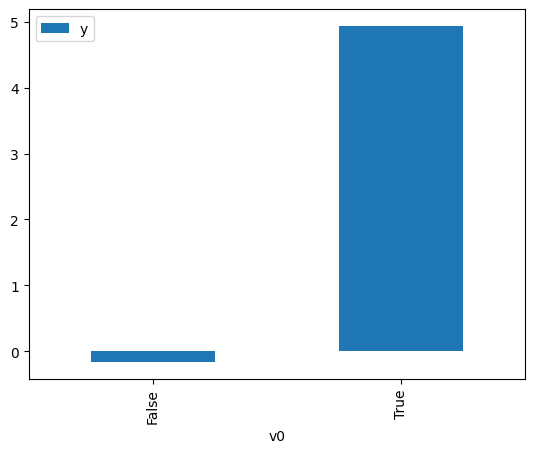

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

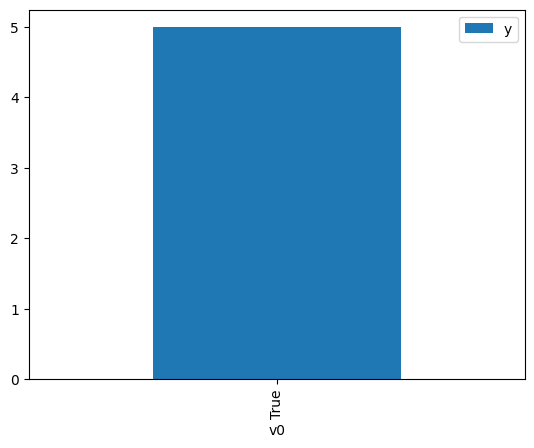

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.157717,False,-2.401010,0.734796,1.360921
1,-0.838878,False,0.461296,0.679849,1.470914
2,-1.021892,False,-0.783775,0.712134,1.404229
3,0.362048,False,-0.978428,0.438098,2.282594
4,-0.658212,False,0.987463,0.646193,1.547526
...,...,...,...,...,...
995,0.608250,False,-1.926270,0.388340,2.575066
996,-1.324057,False,-0.382468,0.760947,1.314152
997,-1.888506,False,-0.821131,0.836007,1.196162
998,0.718132,False,0.917579,0.366799,2.726291


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.343018,True,5.406419,0.236187,4.233927
1,-0.403717,True,5.889422,0.403714,2.477000
2,0.278277,True,5.322908,0.544629,1.836113
3,-0.068127,True,4.772774,0.472522,2.116302
4,-0.743952,True,3.733427,0.337629,2.961835
...,...,...,...,...,...
995,1.276566,True,5.434029,0.733390,1.363531
996,-0.696496,True,5.808143,0.346539,2.885677
997,1.658569,True,4.903925,0.790941,1.264317
998,-0.505800,True,6.220691,0.383390,2.608310


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.913
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                              5223.
Date:                Fri, 19 Aug 2022   Prob (F-statistic):                        0.00
Time:                        21:26:22   Log-Likelihood:                         -1393.4
No. Observations:                1000   AIC:                                      2791.
Df Residuals:                     998   BIC:                                      2801.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2332      0.027      8.508      0.000       0.179       0.287
x2             5.0420      0.049    102.158      0.000       4.945       5.139
==============================================================================
Omnibus:                        1.761   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.414   Jarque-Bera (JB):                1.735
Skew:                          -0.050   Prob(JB):                        0.420
Kurtosis:                       2.823   Cond. No.                         1.81
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""